In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import itertools
import gin
from matplotlib import pyplot as plt 
import numpy as np
import seaborn as sns
import pytorch_lightning
import torch
import scipy 

from deepgen.utils import train_model, test_model
from deepgen.data import get_liner_generator
%matplotlib inline

In [8]:
gin.enter_interactive_mode()
gin.parse_config_file('big_gru_no_embed.gin')

ParsedConfigFileIncludesAndImports(filename='big_gru_no_embed.gin', imports=[], includes=[ParsedConfigFileIncludesAndImports(filename='big_config.gin', imports=['pytorch_lightning', 'deepgen.models', 'deepgen.data'], includes=[])])

# Show distribution of TMRCA in genomes

In [5]:
num_generators = 4
num_genomes = 3
num_classes = 32

data_gen = get_liner_generator(genome_length=30000, random_seed=35, 
                             num_generators=num_generators, num_genomes=num_genomes)

data_gen_c = itertools.cycle(data_gen)

In [18]:
x, y_true = next(data_gen_c)

In [19]:
len(x)

30000

In [20]:
len(y)

30000

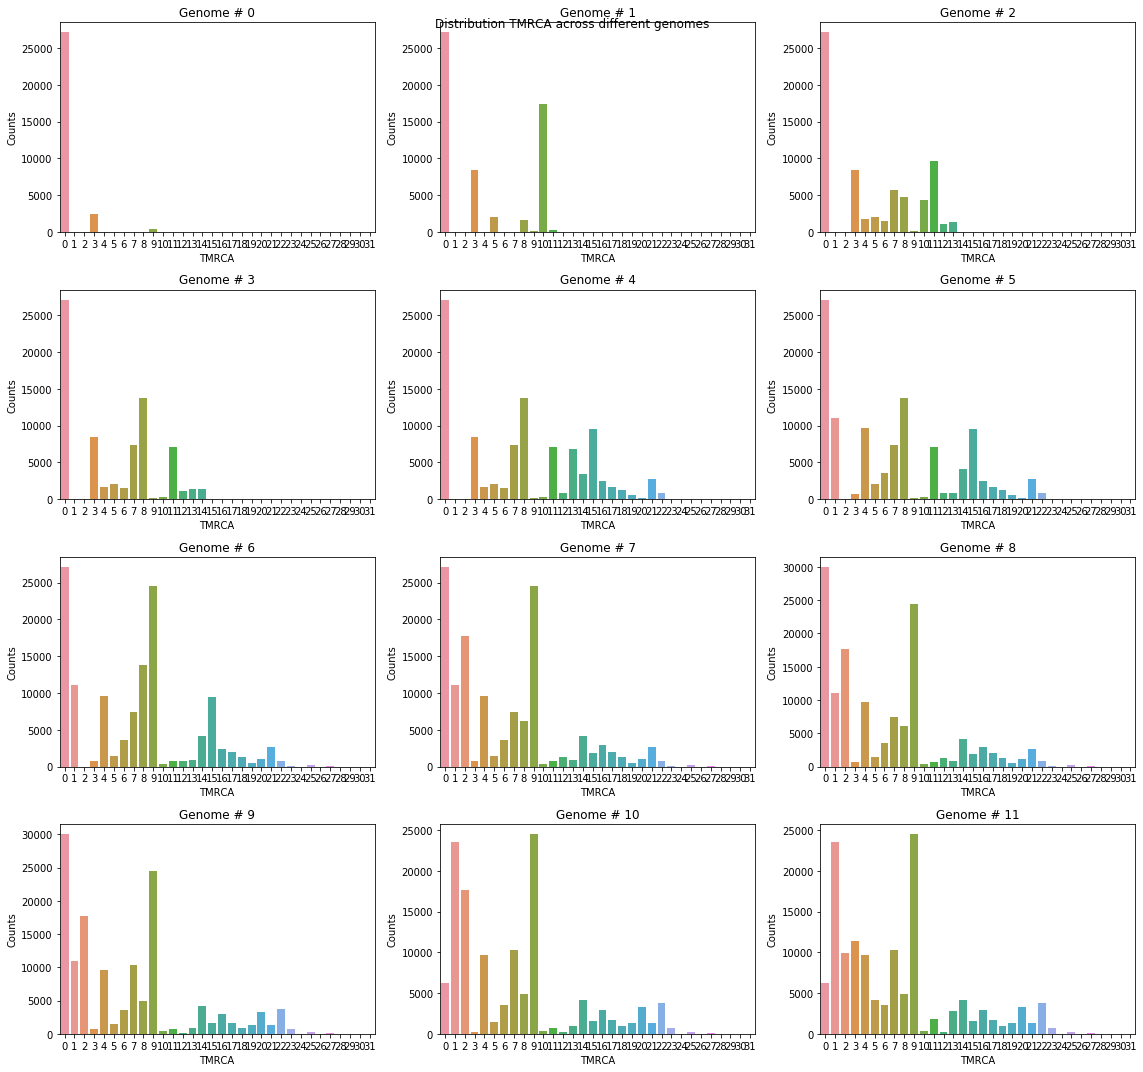

In [5]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 15), tight_layout=True)
axs = np.ravel(axs)

fig.suptitle("Distribution TMRCA across different genomes")

all_class_counts = np.zeros(num_classes)
for i in range(num_generators*num_genomes):
    all_classes_count = np.zeros(num_classes)
    _, y = next(data_gen_c)
    unique, counts = np.unique(y, return_counts=True)
    all_class_counts[unique] = counts
    axs[i].set_title("Genome # " + str(i))
    axs[i].set_xlabel("TMRCA")
    axs[i].set_ylabel("Counts")
    sns.barplot(ax=axs[i], x=np.arange(num_classes), y=all_class_counts)

# Initialize model

In [8]:
from deepgen.models import GruLabeler
import torch

In [12]:
gru_model = GruLabeler()
gru_model = GruLabeler.load_from_checkpoint(checkpoint_path="GRU_trained.ckpt").eval()

# Show distribution of 

In [11]:
import scipy
with torch.no_grad():
    x, y_true = next(data_gen_c)
    
    x = np.array(x)[np.newaxis, :]
    y_true = np.array(y_true)[np.newaxis, :]
    
    y_pred = scipy.special.softmax(gru_model(torch.LongTensor(x)), axis=-1)
    y_pred_arg_max = np.argmax(y_pred, axis=2)

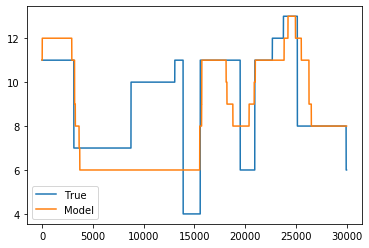

In [12]:
plt.plot(y_true[0], label='True')
plt.plot(y_pred_arg_max[0], label='Model')
plt.legend()

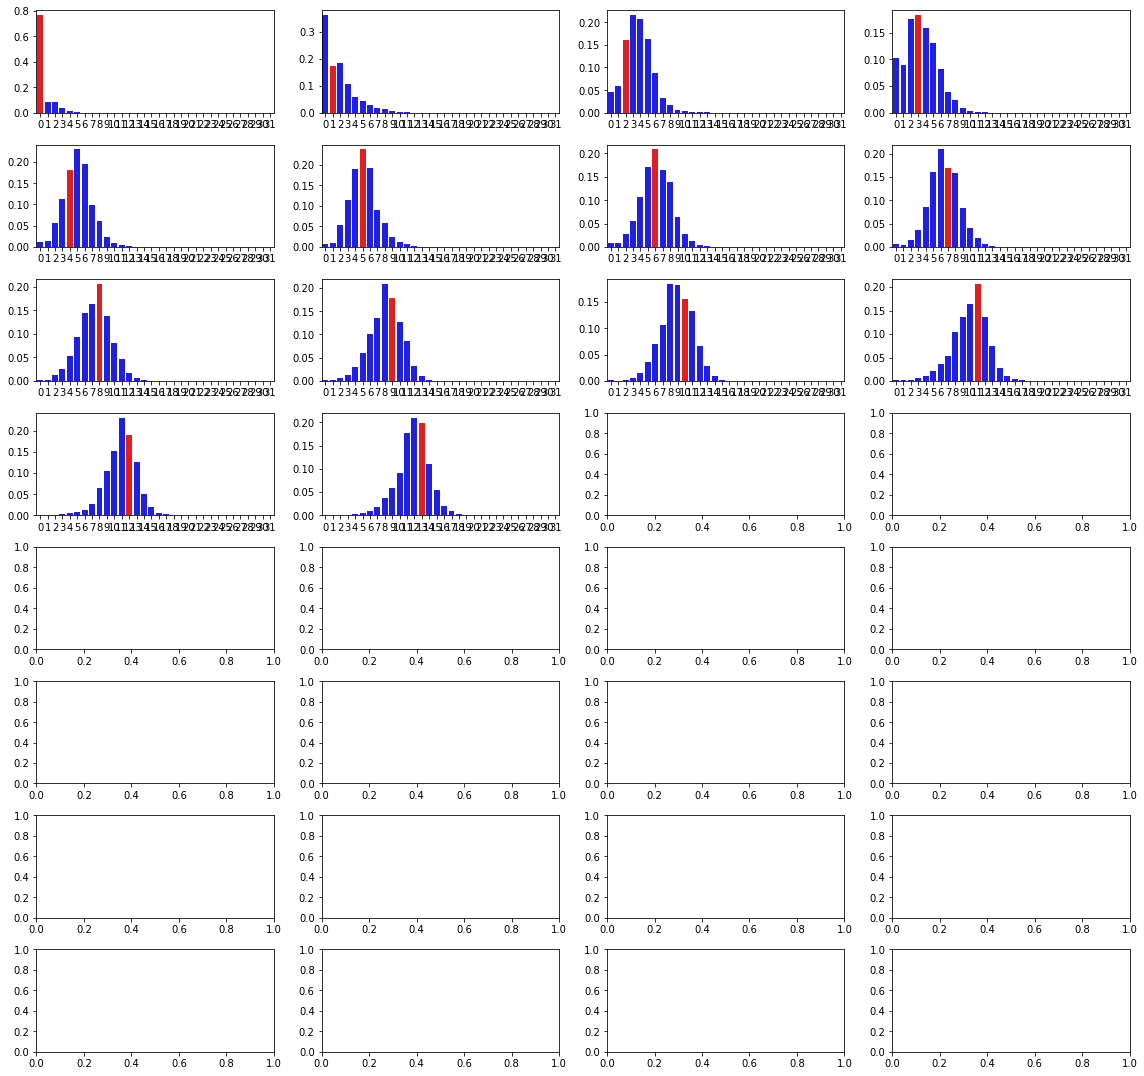

In [107]:
num_classes = 32

fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(16, 15), tight_layout=True)
axs = np.ravel(axs)


y_pred = y_pred.numpy()

for i in range(num_classes):
    row_indices, col_indices = np.where(y_true == i)
    if len(row_indices) == 0:
        continue
    dist = np.sum(y_pred[row_indices, col_indices], axis=0) / np.sum(y_pred[row_indices, col_indices])
    clrs = np.where(np.arange(num_classes) == i, 'red', 'blue')
    sns.barplot(ax=axs[i], x=np.arange(num_classes), y=dist, palette=clrs)

# Toplist 

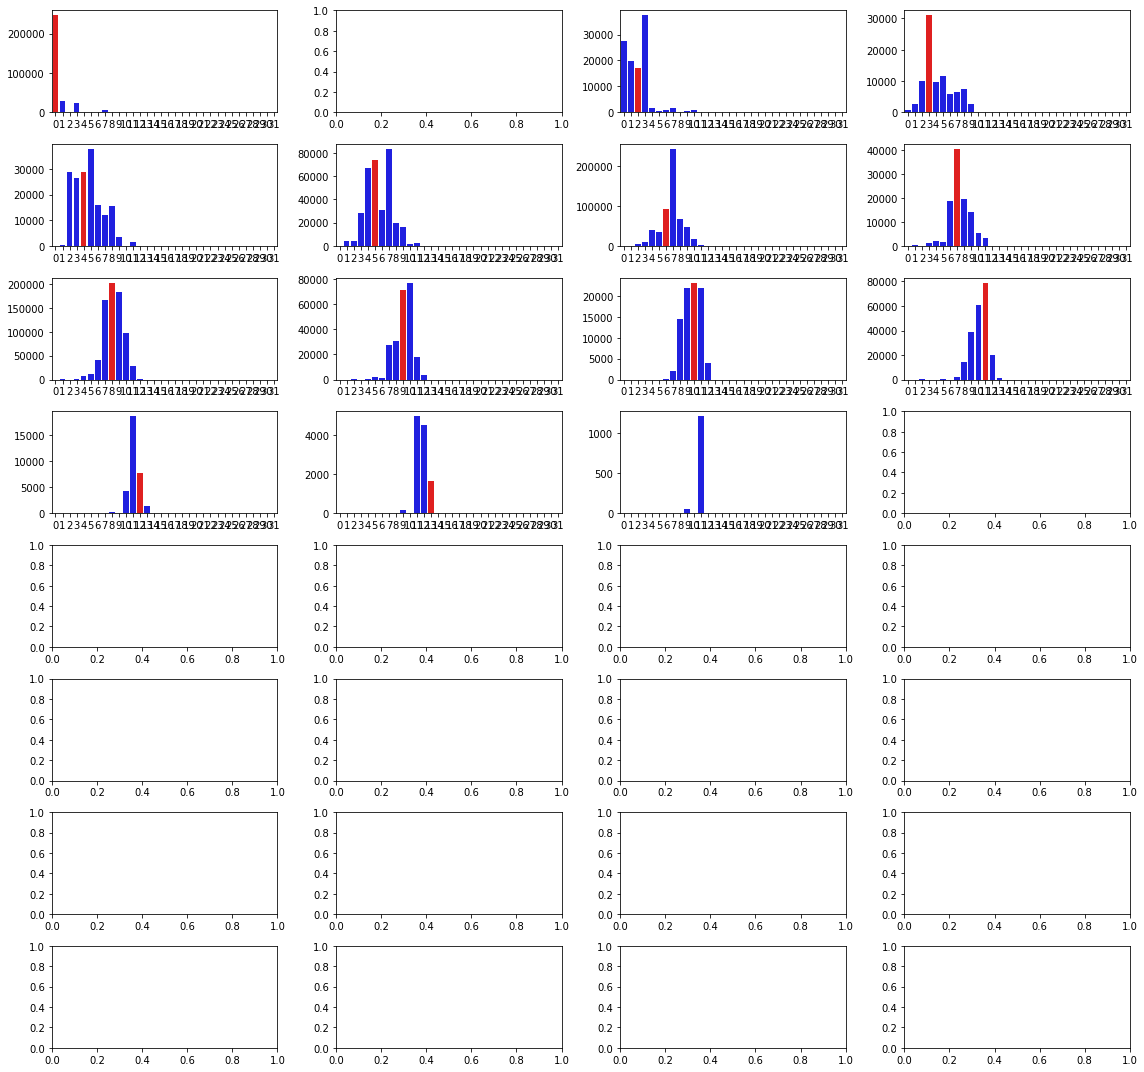

In [108]:
num_classes = 32

fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(16, 15), tight_layout=True)
axs = np.ravel(axs)

for i in range(num_classes):
    all_class_counts = np.zeros(num_classes)
    row_indices, col_indices = np.where(y_pred_arg_max == i)
    if len(row_indices) == 0:
        continue
    clrs = np.where(np.arange(num_classes) == i, 'red', 'blue')
    classes, counts = np.unique(y_true[row_indices, col_indices], return_counts=True)
    all_class_counts[classes] = counts
    sns.barplot(ax=axs[i], x=np.arange(num_classes), y=all_class_counts, palette=clrs)

# Predict

In [7]:
from deepgen.models import GruLabeler
import torch

In [8]:
gru_model = GruLabeler()
gru_model = gru_model.load_from_checkpoint(checkpoint_path="GRU_trained.ckpt").eval()

In [41]:
input_genome

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [42]:
with open("to_compare/0.txt", 'r') as file:
    x = file.read().strip()    
    a = [int(z) for z in list(x)]
    input_genome = torch.FloatTensor(a).unsqueeze(0)
    
    out = gru_model(input_genome)

In [105]:
import scipy
with torch.no_grad():
    x, y_true = next(data_gen_c)
    
    x = np.array(x)[np.newaxis, :]
    y_true = np.array(y_true)[np.newaxis, :]
    
    y_pred = scipy.special.softmax(gru_model(torch.LongTensor(x)), axis=-1)
    y_pred_arg_max = np.argmax(y_pred, axis=2)

/Users/ken/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


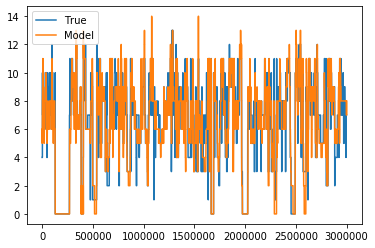

In [106]:
plt.plot(y_true[0], label='True')
plt.plot(y_pred_arg_max[0], label='Model')
plt.legend()

## Markdown 

In [9]:
import seaborn as sns
sns.set_theme()
sns.set_context("paper")


sns.set(rc={'figure.figsize' : (11.7, 8.27),
           'axes.labelsize': 20,
           'axes.titlesize': 20
           }
       )
ax = sns.heatmap(y_pred.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=1000)
ax.plot(y_true[0][:30000], c='red')
_ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")

NameError: name 'y_pred' is not defined

In [10]:
def plot_heatmap(y_pred, y_true, length):
    sns.set(rc={'figure.figsize' : (11.7, 8.27),
           'axes.labelsize': 20,
           'axes.titlesize': 20
           }
       )
    ax = sns.heatmap(y_pred.squeeze(0)[:length].T, cmap="viridis", yticklabels=5, xticklabels=1000)
    ax.plot(y_true[0][:length], c='red')
    _ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")
    plt.show()

# Const

In [6]:
y_true_const = torch.load("../Output/output_const/0_y_true.pt")
y_pred_const = scipy.special.softmax(torch.load("../Output/output_const/0_y_pred.pt"), axis=-1)
y_pred_const_exp = scipy.special.softmax(torch.exp(torch.load("../Output/output_const/0_y_pred.pt")), axis=-1)

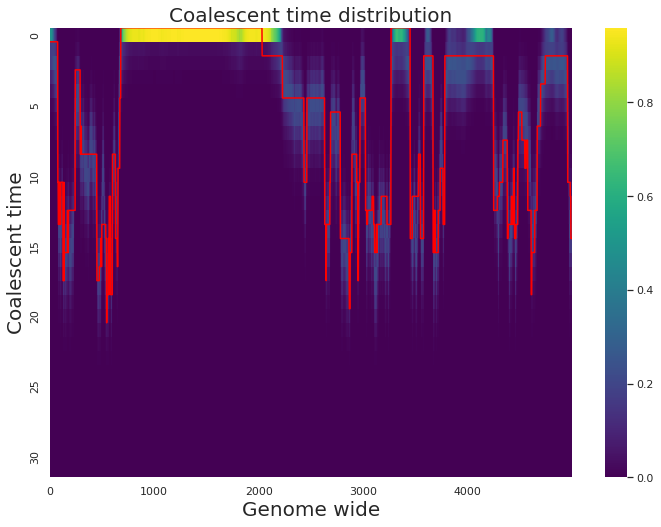

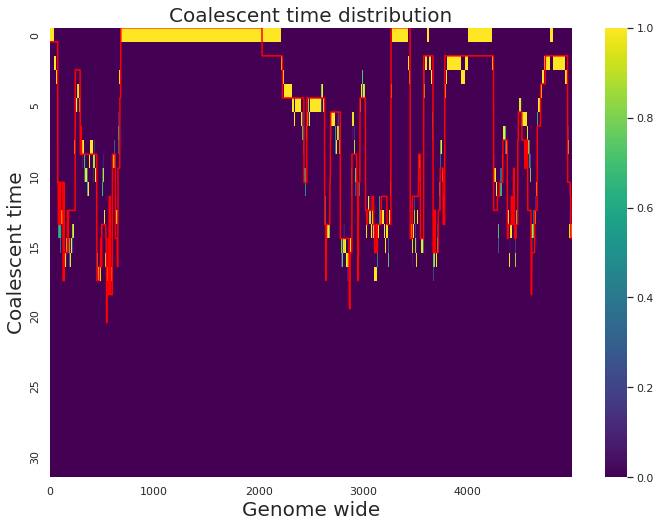

In [7]:
plot_heatmap(y_pred_const, y_true_const, 5000)
plot_heatmap(y_pred_const_exp, y_true_const, 5000)

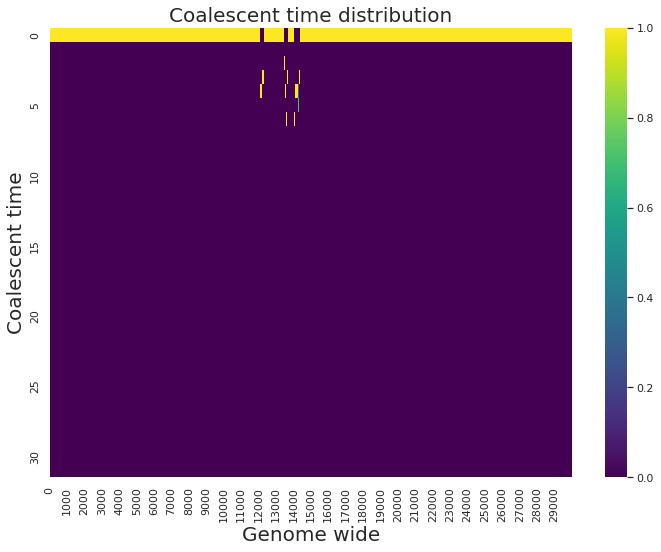

In [8]:
y_pred_const_exp_p = scipy.special.softmax(torch.exp(torch.load("../Output/output_const/to_compare_results/0.pt")), axis=-1)


ax = sns.heatmap(y_pred_const_exp_p.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=1000)
#ax.plot(y_true[0][:30000], c='red')
_ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")

# Test

In [33]:
y_true_test = torch.load("../Output/output_test/0_y_true.pt")
y_pred_test = scipy.special.softmax(torch.load("../Output/output_test/0_y_pred.pt"), axis=-1)

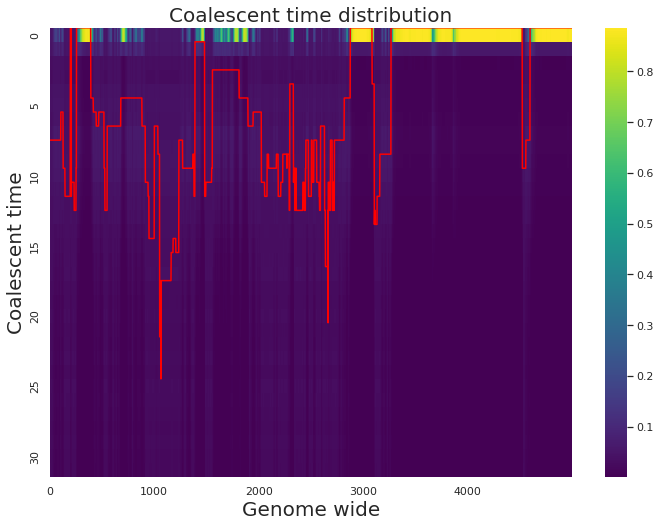

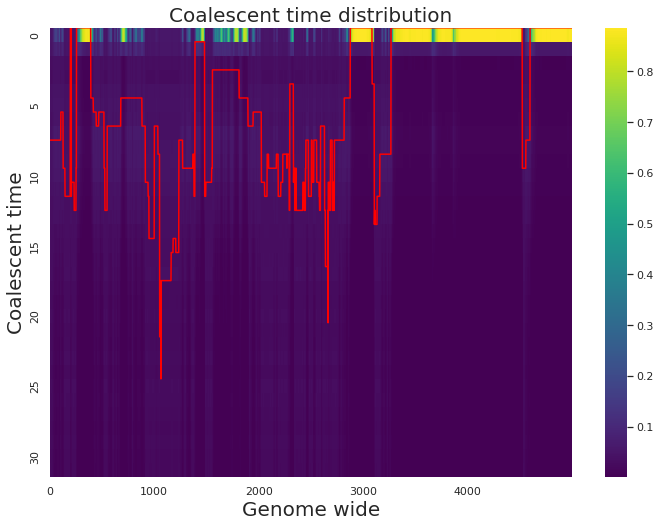

In [34]:
plot_heatmap(y_pred_test, y_true_test, 5000)

## predefined

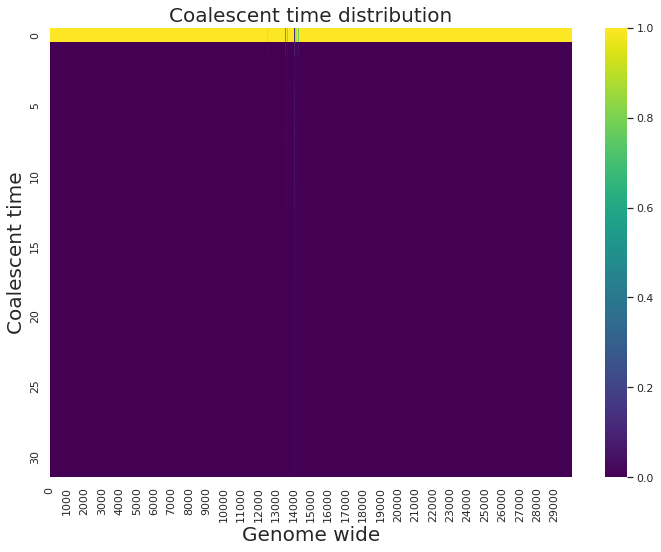

In [11]:
#y_true_test_p = torch.load("../Output/output_test/to_compare_results/0.pt")
y_pred_test_p = scipy.special.softmax(torch.load("../Output/output_test/to_compare_results/0.pt"), axis=-1)
y_pred_test_exp_p = scipy.special.softmax(torch.exp(torch.load("../Output/output_test/to_compare_results/0.pt")), axis=-1)


ax = sns.heatmap(y_pred_test_exp_p.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=1000)
#ax.plot(y_true[0][:30000], c='red')
_ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")


# MS

In [12]:
y_true_ms = torch.load("../Output/output_ms/0_y_true.pt")
y_pred_ms = scipy.special.softmax(torch.load("../Output/output_ms/0_y_pred.pt"), axis=-1)
y_pred_ms_exp = scipy.special.softmax(torch.exp(torch.load("../Output/output_ms/0_y_pred.pt")), axis=-1)

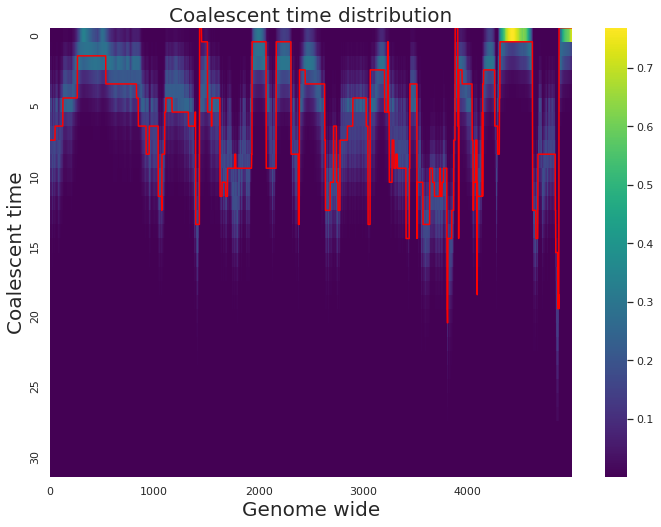

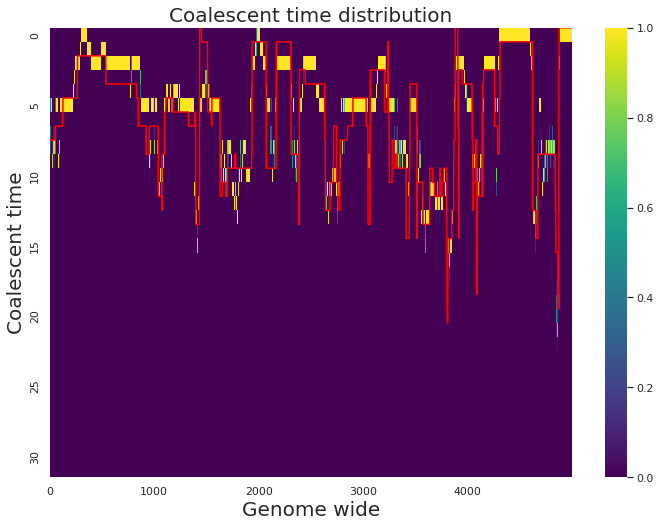

In [13]:
plot_heatmap(y_pred_ms, y_true_ms, 5000)
plot_heatmap(y_pred_ms_exp, y_true_ms, 5000)

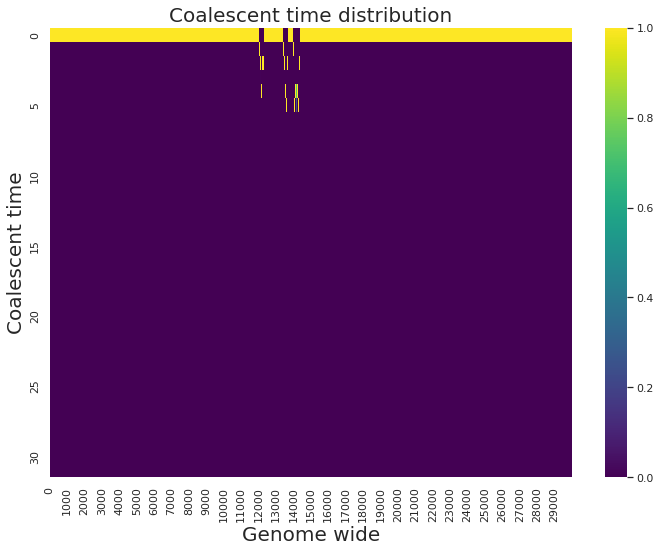

In [14]:
y_pred_ms_exp_p = scipy.special.softmax(torch.exp(torch.load("../Output/output_ms/to_compare_results/0.pt")), axis=-1)


ax = sns.heatmap(y_pred_ms_exp_p.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=1000)
#ax.plot(y_true[0][:30000], c='red')
_ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")

## predefined

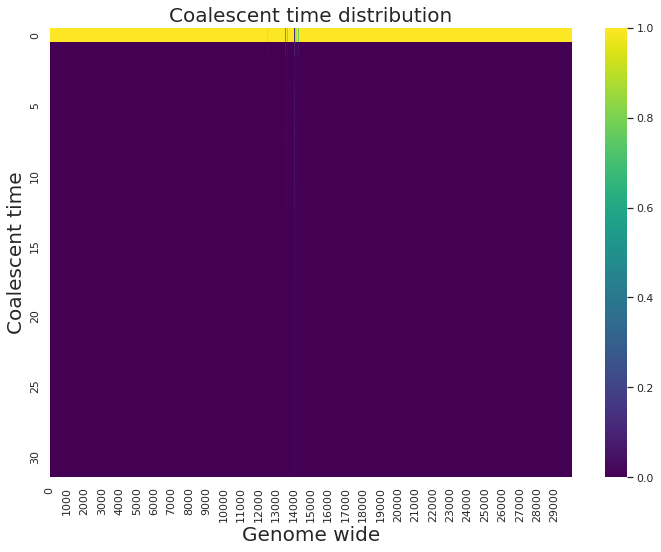

In [15]:
#y_true_test_p = torch.load("../Output/output_test/to_compare_results/0.pt")
y_pred_test_p = scipy.special.softmax(torch.load("../Output/output_test/to_compare_results/0.pt"), axis=-1)
y_pred_test_exp_p = scipy.special.softmax(torch.exp(torch.load("../Output/output_test/to_compare_results/0.pt")), axis=-1)


ax = sns.heatmap(y_pred_test_exp_p.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=1000)
#ax.plot(y_true[0][:30000], c='red')
_ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")


# MS

In [ ]:
y_true_ms = torch.load("../Output/output_ms/0_y_true.pt")
y_pred_ms = scipy.special.softmax(torch.load("../Output/output_ms/0_y_pred.pt"), axis=-1)
y_pred_ms_exp = scipy.special.softmax(torch.exp(torch.load("../Output/output_ms/0_y_pred.pt")), axis=-1)

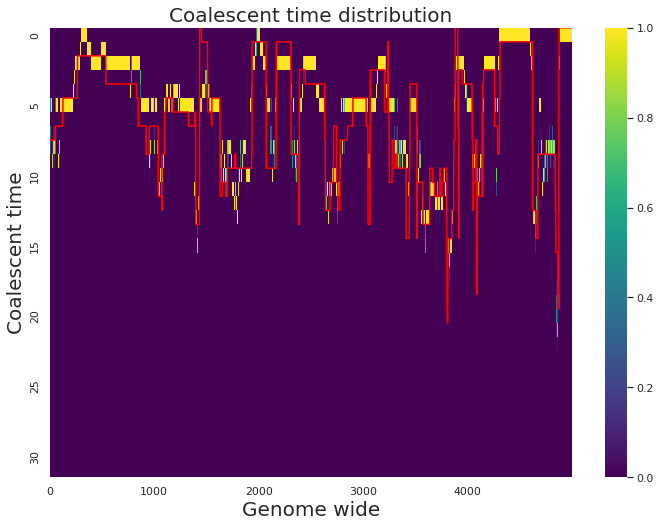

In [42]:
plot_heatmap(y_pred_ms_exp, y_true_ms, 5000)

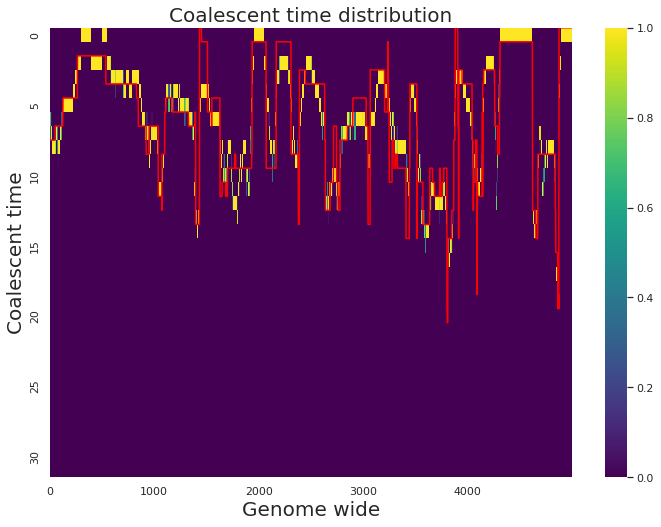

In [51]:
plot_heatmap(scipy.special.softmax(torch.exp(y_pred_ssss), axis=-1), y_true_ms, 5000)

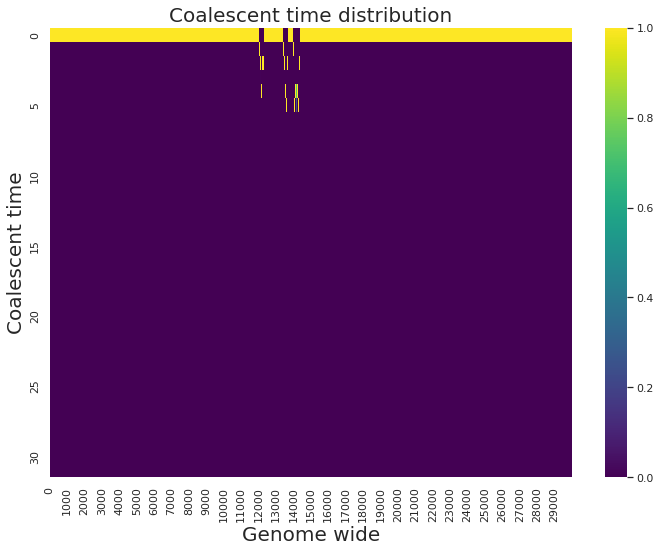

In [27]:
y_pred_ms_exp_p = scipy.special.softmax(torch.exp(torch.load("../Output/output_ms/to_compare_results/0.pt")), axis=-1)


ax = sns.heatmap(y_pred_ms_exp_p.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=1000)
#ax.plot(y_true[0][:30000], c='red')
_ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")

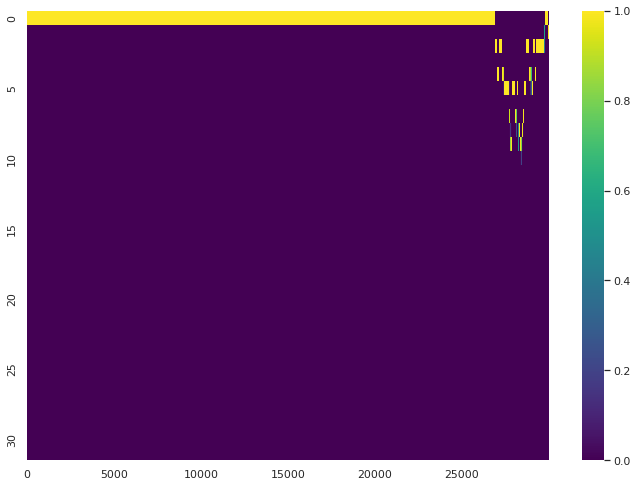

In [35]:
yyyy = scipy.special.softmax(torch.exp(torch.load("output_ms/to_compare_results_conv/2.pt")), axis=-1)


ax = sns.heatmap(yyyy.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=5000)
#_ = ax.set(xlabel='Genome wide', ylabel='Coalescent time', title="Coalescent time distribution")

# Check Const weight on different demographies

In [31]:
def myexp(data):
    return scipy.special.softmax(data, axis=-1)

In [12]:
from deepgen.models import ConvEmbedding

gru_model_const = GruLabeler.load_from_checkpoint("../Output/output_const/GRU.ckpt").eval()

x_true_const = torch.load("../Output/output_const/0_x.pt")
x_true_test = torch.load("../Output/output_test/0_x.pt")
x_true_ms = torch.load("../Output/output_ms/0_x.pt")

y_true_const = torch.load("../Output/output_const/0_y_true.pt")
y_true_test = torch.load("../Output/output_test/0_y_true.pt")
y_true_ms = torch.load("../Output/output_ms/0_y_true.pt")

In [13]:
%%time
with torch.no_grad():
    y_ms_model_pred_on_const = myexp(gru_model_const(x_true_const))
    y_ms_model_pred_on_test = myexp(gru_model_const(x_true_test))
    y_ms_model_pred_on_ms = myexp(gru_model_const(x_true_ms))

CPU times: user 2min 19s, sys: 5.73 s, total: 2min 24s
Wall time: 22.1 s


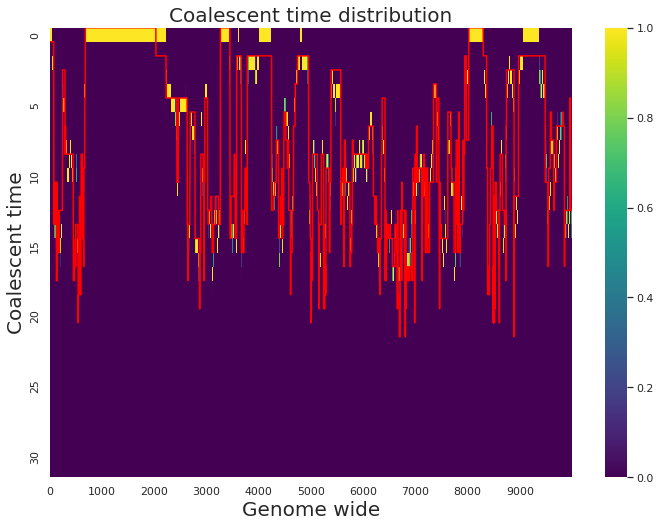

In [14]:
plot_heatmap(y_ms_model_pred_on_const, y_true_const, 10000)

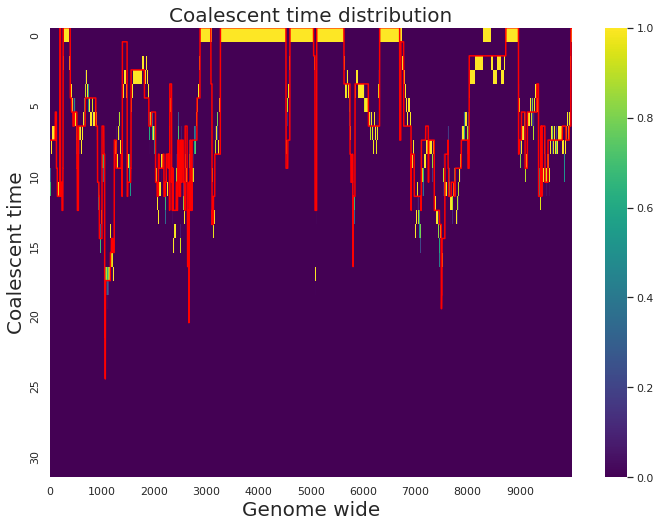

In [59]:
plot_heatmap(y_ms_model_pred_on_test, y_true_test, 10000)

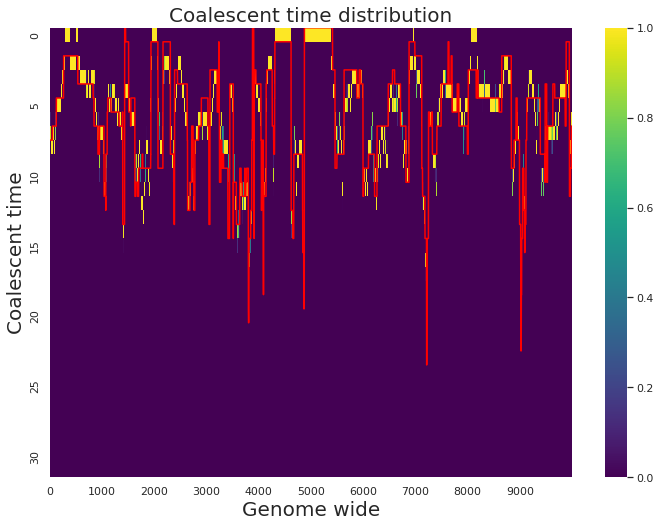

In [60]:
plot_heatmap(y_ms_model_pred_on_ms, y_true_ms, 10000)

### Special demography

In [61]:
filename = "to_compare/" + str(0) + ".txt"
genome = open(filename).read().strip()
a = [int(num) for num in list(genome)]
input_genome = torch.FloatTensor(a).unsqueeze(0)

In [64]:
np.count_nonzero(input_genome)

7129

In [65]:
with torch.no_grad():
    out_genome = myexp(gru_model_const(input_genome))

In [66]:
out_genome

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]])

In [75]:
np.count_nonzero(input_genome)

7129

In [76]:
np.count_nonzero(x_true_const)

10321

10321


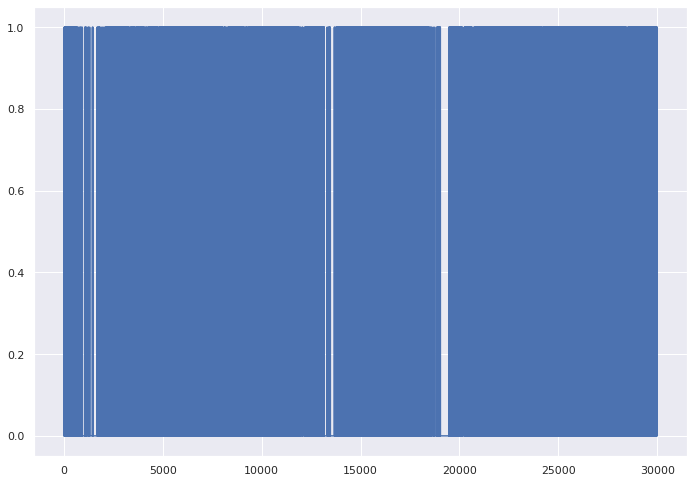

In [119]:
plt.plot(x_true_const[0])
print(np.count_nonzero(x_true_const))

5347

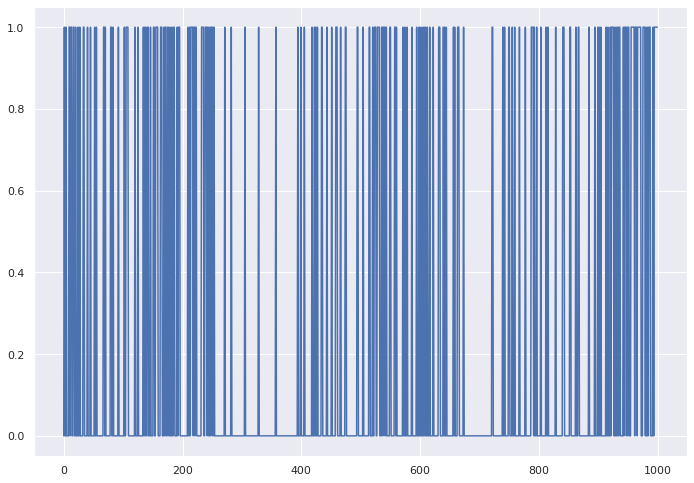

In [132]:
plt.plot(x_true_test[0][:1000])
np.count_nonzero(x_true_test)

1048

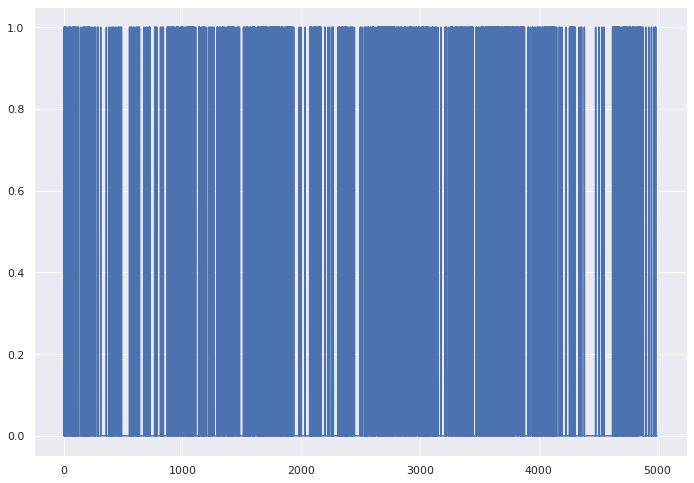

In [126]:
plt.plot(x_true_ms[0][:5000])
np.count_nonzero(x_true_ms[0][:5000])

In [130]:
input_genome.shape

torch.Size([1, 300001])

7129

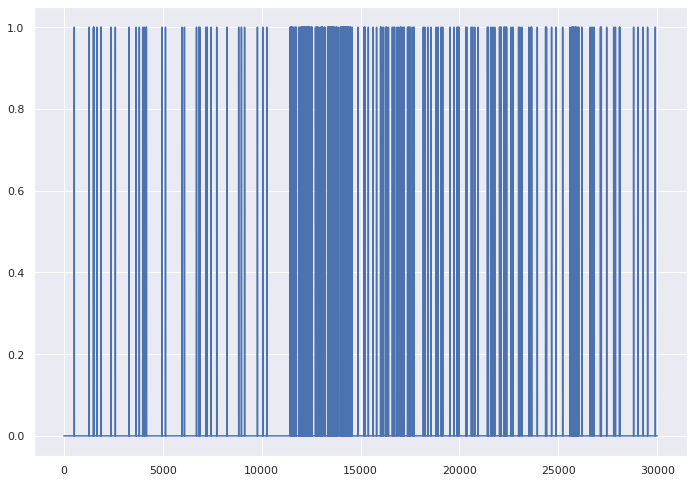

In [129]:
plt.plot(input_genome[0][:30000])
np.count_nonzero(input_genome[0])

In [91]:
gin.enter_interactive_mode()
gin.parse_config_file('configs/big_gru.gin')

conv_gru_model_ms = GruLabeler.load_from_checkpoint("output_ms/GRU-conv-trained.ckpt").eval()

In [98]:
%%time
with torch.no_grad():
    y_convgru_const = myexp(conv_gru_model_ms(x_true_const))
    y_convgru_test = myexp(conv_gru_model_ms(x_true_test))
    y_convgru_ms = myexp(conv_gru_model_ms(x_true_ms))
    
    
    y_convgru_special = myexp(conv_gru_model_ms(input_genome))

CPU times: user 5min 16s, sys: 18.1 s, total: 5min 34s
Wall time: 2min


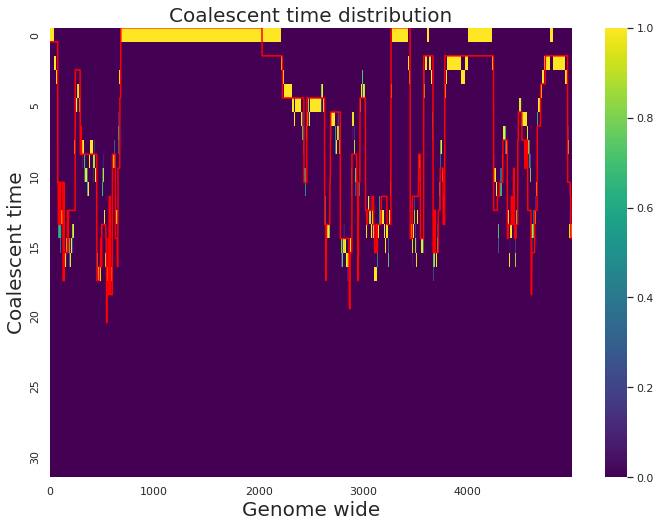

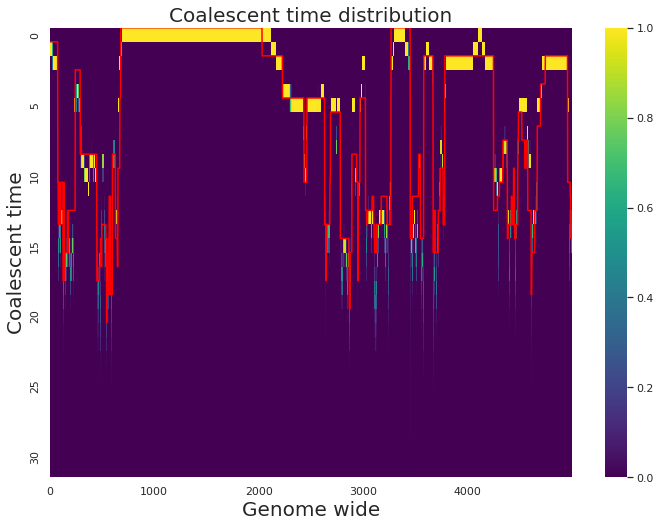

In [95]:
plot_heatmap(y_ms_model_pred_on_const, y_true_const, 5000)
plot_heatmap(y_convgru_const, y_true_const, 5000)

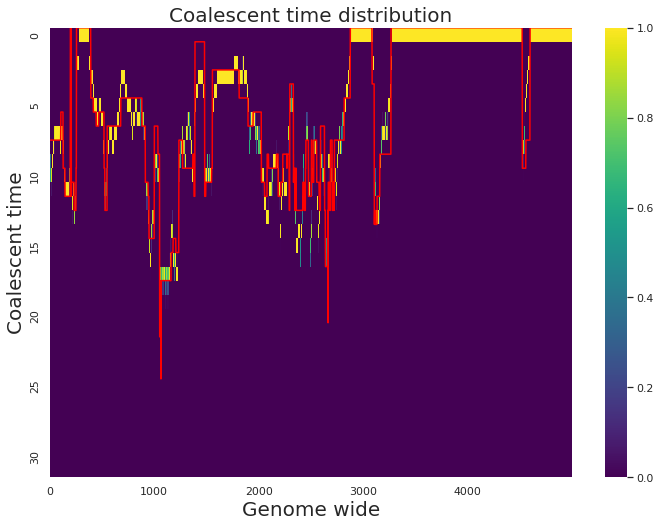

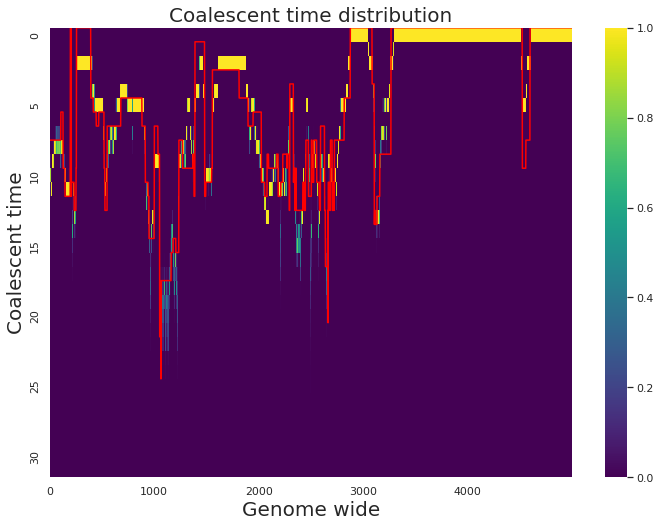

In [96]:
plot_heatmap(y_ms_model_pred_on_test, y_true_test, 5000)
plot_heatmap(y_convgru_test, y_true_test, 5000)

In [100]:
%%time
with torch.no_grad():
    y_gru_special = myexp(gru_model_const(input_genome))
    y_convgru_special = myexp(conv_gru_model_ms(input_genome))

CPU times: user 4min 43s, sys: 15.7 s, total: 4min 59s
Wall time: 2min 41s


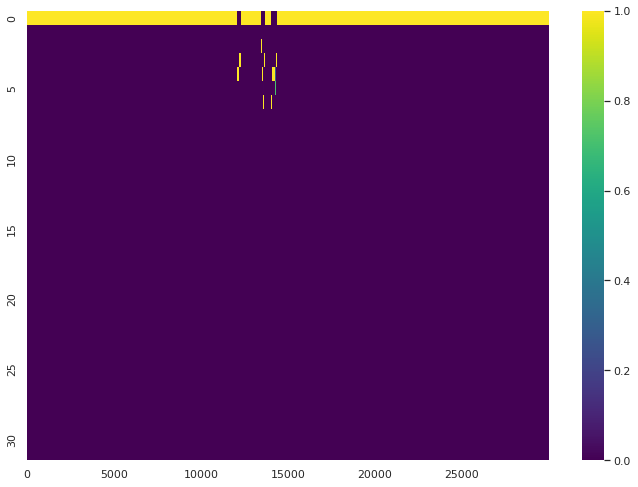

In [101]:
ax = sns.heatmap(y_gru_special.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=5000)

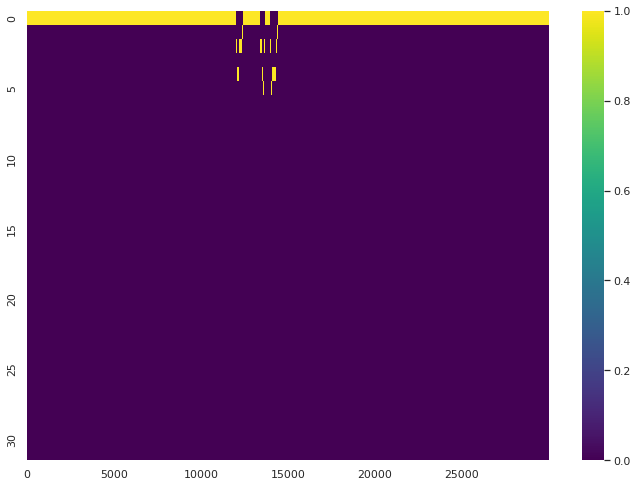

In [99]:
ax = sns.heatmap(y_convgru_special.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=5000)

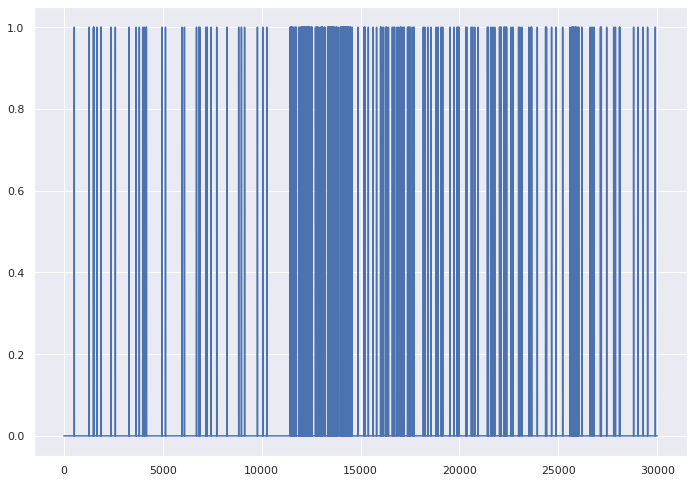

In [107]:
plt.plot(input_genome[0][:30000])

In [110]:
np.count_nonzero(input_genome)

7129

In [131]:
np.count_nonzero(x_true_ms)

5721

In [26]:
yy = myexp(torch.load("output_const_big_test/y_pred_1.pt"))
y_true = torch.load("output_const_big_test/y_true_1.pt")

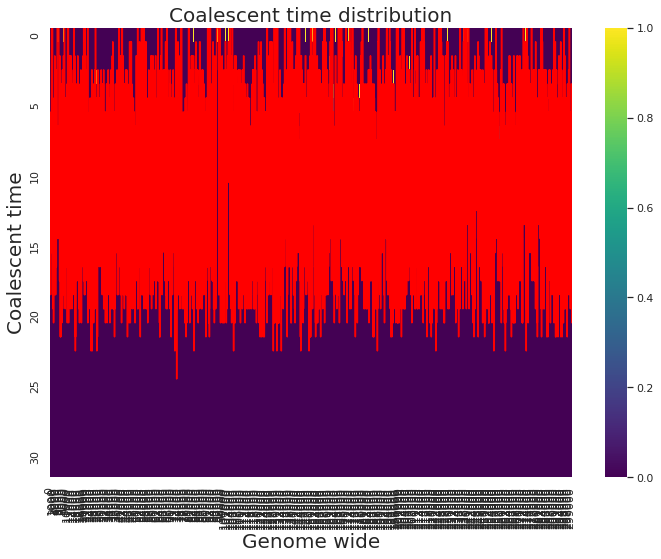

In [27]:
plot_heatmap(yy, y_true, 300000)

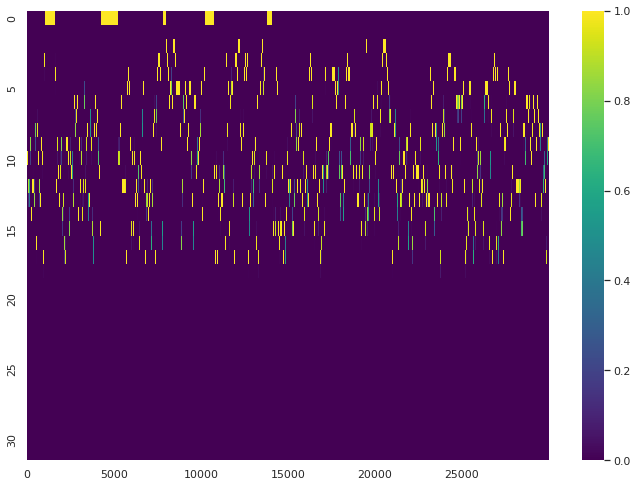

In [28]:
ax = sns.heatmap(yy.squeeze(0)[:30000].T, cmap="viridis", yticklabels=5, xticklabels=5000)

In [17]:
xx_true = torch.load("output_const_big_test/x_3.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'output_const_big_test/x_3.pt'

In [18]:
xx_true.shape

NameError: name 'xx_true' is not defined

In [153]:
np.count_nonzero(xx_true)

0

In [1]:
import gin
import numpy as np
import torch
import pytorch_lightning
from deepgen.models import GruLabeler
from deepgen.data import DatasetXY
from deepgen.utils import train_model, test_model
from tqdm import tqdm


gin.parse_config_file('configs/big_gru.gin')
gru_model = GruLabeler.load_from_checkpoint(checkpoint_path="../Output/output_const/GRU.ckpt").eval()
dataset = DatasetXY()

In [2]:
X, Y = next(iter(dataset.test_dataloader()))

In [4]:
X

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [5]:
np.count_nonzero(X)

0

In [ ]:
gin.config.